In [14]:
# Libraries to access external data
# PyVO provides generic access to VO protocols (ex: TAP)
import pyvo
# astroquery modules are specific to astronomy services, there are not necessarily VO,
# but more and more do switch to VO protocols these days
# here we import the MOCServer and Vizier modules
from astroquery.mocserver import MOCServer 
from astroquery.vizier import Vizier

# The mocpy library is an astropy-affiliated library
# It allows to manipulate MOCs
from mocpy import STMOC, MOC, TimeMOC, WCS

# General astropy utilitary methods and classes
from astropy.coordinates import Longitude, Latitude, Angle, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u

# For vizaulisation
import matplotlib.pyplot as plt
from sidecar import Sidecar
from ipyaladin import Aladin


# Accessing data through space and time criteria

## This notebook focuses on the use of the Multi-Order Coverage (MOC) and Space-Time MOC (STMOC) for querying and analyzing astronomical data. 

### Key words:

**Hierarchical Progressive Survey (HiPS)**: HiPS describes a generic method for packaging, storing, querying, and describing astronomical data. It stores data in a folder structure that mimics the [HEALPix tesselation of the sky](https://healpix.jpl.nasa.gov/pdf/intro.pdf).

**Multi-Order Coverage (MOC)**: MOC is a data structure used to describe arbitrary regions of the sky with variable resolution. It is particularly useful for handling large-scale astronomical surveys and for efficiently querying regions of interest.

**Space-Time MOC (STMOC)**: STMOC extends the concept of MOC to include the temporal dimension, allowing for the representation of regions of the sky that change over time. This is useful for time-domain astronomy, where the visibility of sources varies.

### Scientific Motivation:

Gamma-Ray Bursts (GRBs) are among the most energetic and mysterious phenomena in the universe. These brief but intense flashes of gamma rays are believed to originate from cataclysmic events such as the collapse of massive stars or the merger of neutron stars. Observing GRBs across multiple wavelengths and with different telescopes provides crucial insights into their nature and origins. In this study, we focus on GRBs observed by the Fermi Gamma-ray Space Telescope and the XMM-Newton X-ray Observatory, and demonstrate how the use of Space-Time Multi-Order Coverage (STMOC) can help identify and analyze these fascinating events.

## Looking for HiPS surveys

HiPS is a way of storing data sets (it can be catalogs, or images for example) that follows the HEALPix tessalation of the sky. This is particularly optimized for vizualisation.

![HiPS_and_the_HEALPix_grid](HiPS_and_the_HEALPix_grid.png)

Figure: (a) In the HiPS standard, a folder corresponds to a HEALPix order. The example images are from a SDO/AIA observation of the Sun. At all orders, the images have the same number of pixels (here 512*512), but they represent a different sky fraction. We see that the pixel 0 at order 3 contains the pixel 0 and 1 of the more precise order. (b) The healpix grid can be added to the ipyaladin view. If you zoom in and out and move like crazy (or if you have a slower internet connexion), you'll see the images that appear as they are downloaded by ipyaladin.

More and more astronomical data centers start to offer this format for sky vizualizations.

One place where HiPS can be found is the MOCServer, one of the services of the CDS. We will use the module `mocserver` from the `astroquery` library.

Here we query the MOC server to find HiPS datasets related to Fermi observations. Fermi cameras are sensitive to sources that emit in gamma-rays. GRBs are the ideal candidate for Fermi.

In [3]:
fermi_hips = MOCServer.find_datasets(meta_data="obs_description=*Fermi*&&hips_*=*", casesensitive=False)

In [4]:
fermi_hips["ID"]

CDS/P/Fermi/3
CDS/P/Fermi/4
CDS/P/Fermi/5
CDS/P/Fermi/color
ov-gso/P/Fermi/Band1
ov-gso/P/Fermi/Band2
ov-gso/P/Fermi/Band3
ov-gso/P/Fermi/Band4
ov-gso/P/Fermi/Band5


## 
GRBs can be studied in conjunction with other instruments spanning wide range of wavelengths in order to understand the various propoerties of the GRB. The bursts of gamma-rays produced b the GRBs, collide with each other and also the interstellar medium and produce what we call the "after glow". The "after glow" contains electromagnetic radiaitons ranging from X-rays to radio. Let's explore the GRBs also detected in X-rays. As shown above, we can obtain HiPs for the XMM-Newton Telescope. XMM-Newton is a powerful telescope that observes the X-ray Universe. 

In [5]:
xmm_hips = MOCServer.find_datasets(meta_data="obs_description=*xmm*&&hips_*=*", casesensitive=False)
xmm_hips

hips_creator,obs_description,hips_estsize,hips_creation_date,hips_initial_ra,moc_type,hips_data_range,client_application,hips_progenitor_url,dataproduct_subtype,hips_service_url_1,hips_rgb_blue,hips_check_code,hips_frame,obs_title,data_pixel_bitpix,obs_collection,hips_copyright,hips_status,ID,hips_order_min,hips_pixel_scale,obs_initial_ra,obs_initial_fov,hips_pixel_bitpix,t_max,hips_tile_format,hips_status_2,hips_version,obs_copyright_url,dataproduct_type,moc_order,moc_time_range,client_category,hips_builder,hips_rgb_red,hips_pixel_cut,hips_service_url,hips_sampling,obs_initial_dec,hips_nb_tiles,moc_sky_fraction,hips_service_url_2,hips_release_date,creator_did,em_min,obs_ack,bib_reference_url,t_min,hipsgen_params,obs_regime,TIMESTAMP,hips_order,hips_initial_fov,hips_hierarchy,bib_reference,hips_tile_width,moc_time_order,prov_progenitor,hips_initial_dec,hips_overlay,obs_copyright,hipsgen_date,em_max,s_pixel_scale,hips_status_1,hips_rgb_green
str38,str153,float64,str17,float64,str5,str18,str10,str43,str5,str55,str31,str30,str10,str62,object,str14,str30,str26,str21,float64,float64,float64,float64,object,float64,str8,str24,float64,str27,str5,float64,float64,str15,str22,str30,str13,str33,object,float64,float64,float64,str58,str17,str27,float64,str42,str64,float64,str214,str5,float64,float64,float64,str6,str19,float64,float64,str55,float64,object,str24,str17,float64,float64,str24,str32
L. Michel [Observatoire de Strasbourg],Colored image made with all PN images of the 4xmmdr12: Red=0.5-1Kev Green=1-2Kev Blue=2-4.5Kev - Healpixilized by Michel L. [Observatoire de Strasbourg],--,2023-06-05T14:24Z,23.4621,stmoc,--,AladinLite,--,color,https://alasky.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_color,test [1.0E-6 NaN 4.0E-4 Linear],--,equatorial,False color X-ray images (Red=0.5-1 Green=1-2 Blue=2-4.5 Kev ),--,XMM PN colored,(c) Observatoire de Strasbourg,public master clonableOnce,xcatdb/P/XMM/PN/color,0.0,0.0008946,23.4621,0.4580648549089874,--,59912.0,png,public mirror unclonable,1.4,https://xmmssc.irap.omp.eu/,image,7.0,1.0,Image/X-ray/XMM,Aladin/HipsGen v12.060,red [1.0E-6 NaN 4.0E-4 Linear],--,https://xcatdb.unistra.fr/PNColor,--,30.65994167,--,0.09202,https://alaskybis.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_color,2023-06-05T14:31Z,ivo://xcatdb/P/XMM/PN/color,2.7552e-10,"Galhecos-Team (Strasbourg), SSC XMM-Newton",https://ui.adsabs.harvard.edu/abs/2020A%26A...641A.136W/abstract,51577.0,inRed=/bigarchesbox/michel/xmm_hips/hips_red inGreen=/bigarchesbox/michel/xmm_hips/hips_green/ inBlue=/bigarchesbox/michel/xmm_hips/hips_blue out=/bigarchesbox/michel/xmm_hips/RGB RGB id=ivo://xcatdb/P/XMM/PN/color,X-ray,1698394027940.0,7.0,1.0,--,2020A&A...641A.136W,512.0,25.0,XMM-Newton 4XMM PN images and exposure maps,30.65994167,overlayMean mergeOverwriteTile treeMedian,(c) ESA / SSC XMM-Newton,2023-06-05T14:24Z,6.1992e-10,--,public mirror unclonable,green [1.0E-6 NaN 4.0E-4 Linear]
L. Michel [Observatoire de Strasbourg],Image made with all PN images of the 4xmmdr13 in band 0.5-1Kev - Healpixilized by L. Michel [Observatoire de Strasbourg],73959916.0,2023-06-05T13:26Z,23.4621,stmoc,-0.002862 0.008587,--,https://xcatdb.unistra.fr/PNRed/HpxFinder,--,https://alasky.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_eb2,--,png:2167619521 fits:1120067023,equatorial,X-ray images on band 0.5-1Kev,"['-64', '-64']",4XMM PN eb2,(c) Observatoire de Strasbourg,public master clonableOnce,xcatdb/P/XMM/PN/eb2,0.0,0.0008946,23.4621,0.4580648549089874,"['-64', '-64']",59912.0,png fits,public mirror unclonable,1.4,https://xmmssc.irap.omp.eu/,image,7.0,1.0,Image/X-ray/XMM,Aladin/HipsGen v12.060,--,1.0E-6 4.0E-4,https://xcatdb.unistra.fr/PNRed,"['bilinear', 'bilinear']",30.65994167,71326.0,0.09202,https://alaskybis.cds.unistra.fr/SSC/xcatdb_P_XMM_PN_eb2,2023-06-05T13:27Z,ivo://xcatdb/P/XMM/PN/eb2,2.7552e-10,"Galhecos-Team (Strasbourg), SSC XMM-Newton",https://ui.adsabs.harvard.edu/abs/2020A%26A...641A.136W/abstract,51577.0,"in=/bigarchesbox/michel/xmm_hips/red out=/bigarchesbox/michel/xmm_hips/h

In [6]:
xmm_hips["ID"]

xcatdb/P/XMM/PN/color
xcatdb/P/XMM/PN/eb2
xcatdb/P/XMM/PN/eb3
xcatdb/P/XMM/PN/eb4


Now in aladin

## Aladin

We can integrate the Aladin Lite sky atlas into a Jupyter Notebook. It aids in visualisation and exploration of of astronomical images and data. 

In [7]:
sidecar = Sidecar(title='aladin')
aladin = Aladin(survey="CDS/P/Fermi/color", height=600)
with sidecar:
    display(aladin)

In [8]:
aladin.coo_frame = "galactic"

In [9]:
#aladin.overlay_survey = "CDS/P/MeerKAT/Galactic-Centre-1284MHz-StokesI"

In [10]:
aladin.overlay_survey="xcatdb/P/XMM/PN/color"

In [11]:
aladin.overlay_survey_opacity = 0.8


#I cant see any display

## Vizier catalog for xmm log

# 
Now we make use of the "pyvo" library which allows us to access the virtual observatory services, such as TAP (Table Access Protocol) service provided by VizieR at CDS. This service allows for querying a wide range of astronomical data stored in VizieR.

Using this service, we can easily access the log of observations XMM-NEWTON & Fermi.  This allows us to obtain important information that can find specific observations that match certain criteria, such as time of observation, celestial coordinates, target name, or observation ID. Such observation logs often cantain information about the data quality, data availability, cross-matching catalogues and much more.


In [12]:
# give the address of the service, you can also directly visit the website
tap_vizier = pyvo.dal.TAPService("https://tapvizier.cds.unistra.fr/TAPVizieR/tap")

In [13]:
# access to vizier metadata
result = tap_vizier.search("select * from TAP_SCHEMA.tables where schema_name = 'metaviz'").to_table()
result.pprint_all()

schema_name   table_name   table_type                                                  description                                                   utype nrows
----------- -------------- ---------- -------------------------------------------------------------------------------------------------------------- ----- -----
    metaviz        METAmor      table                                Contains details of Anchor Generation ( Francois Ochsenbein, Isabelle Bourekeb)          31
    metaviz        METApop      table                           Popularity of catalog including all clones ( Francois Ochsenbein, Isabelle Bourekeb)           0
    metaviz        METAucd      table                                     UCD1+ Unified Content Descriptor ( Francois Ochsenbein, Isabelle Bourekeb)         515
    metaviz       METAtime       view                                                  Time catalogue view ( Francois Ochsenbein, Isabelle Bourekeb)           0
    metaviz        METAdba      ta

In [40]:
metacatcols = tap_vizier.search("select * from columns where table_name = 'METAcat'").to_table()
metacatcols

table_name,column_name,description,unit,ucd,utype,datatype,size,principal,indexed,std
object,object,object,object,object,object,object,int32,int32,int32,int32
METAcat,catid,Identification of catalog,,meta.code;meta.dataset,,INTEGER,-1,0,0,1
METAcat,kslot,Slot number in Kohonen map [0 .. 99],,meta.code.class,,SMALLINT,-1,0,0,1
METAcat,status,"0x80=Obsolete, 0x40=noQbox, 0x10=inPrep, 0=OK",,meta.code.status,,SMALLINT,-1,0,0,1
METAcat,catype,"Catalog type: 1=Model 2=Observation 4=Compilation, 5=Critical Comp., 6=General Comp.",,meta.code.class,,SMALLINT,-1,0,0,1
METAcat,name,Catalog designation (CDS),,meta.id;meta.dataset;meta.main,,VARCHAR,-1,0,0,1
METAcat,title,Short title of catalog,,meta.title,,VARCHAR,-1,0,0,1
METAcat,bibcode,Reference of the catalogue,,meta.bib.bibcode,,CHAR(19),19,0,0,1
METAcat,authors,Authors of catalog (comma-separated),,meta.bib.author,,VARCHAR,-1,0,0,1
METAcat,explain,Comments and historical notes about the catalog,,meta.title,,VARCHAR,-1,0,0,1


In [41]:
# catalogs are in metacat
xmm_DR13 = tap_vizier.search("""select top 1 * from METAcat
                  where title like '%XMM%' and title like'%DR13%'
                  """).to_table()
xmm_DR13

catid,kslot,status,catype,name,title,bibcode,authors,explain,popu,authid,flags,doi,orcid,artdoi
int32,int16,int16,int16,object,object,object,object,object,int32,int32,int32,object,object,object
9069,64,0,2,IX/69,"XMM-Newton Serendipitous Source Catalogue 4XMM-DR13 (Webb+, 2023)",2020A&A...641A.136W,"Webb N.A., Coriat M., Traulsen I., et al.",Detailed description and explanations are available in the \W{xplain}{http://xmmssc.irap.omp.eu/Catalogue/4XMM-DR13/4XMM_DR13.html}{public pages} of the {\bf 4XMM-DR13 Catalogue},-1,0,0,,,10.1051/0004-6361/201937353


In [42]:
#Vizier.find_catalogs(["xmm", "log"])

In [43]:
# tables are in metatab
xmm_DR13_tables = tap_vizier.search(
    """select * from METAtab
    where catid = 9069
    """
).to_table()
xmm_DR13_tables

name,dbname,dbaid,catid,tabid,notid,flags,equinox,epoch,cooframe,status,explain,comment,records,loadate,release,filename,cooprec,morexplain
,,,,,,,yr,yr,,,,,,,,,mas,
object,object,int16,int32,int16,int16,int16,int16,float64,int16,int16,object,object,int64,int32,int32,object,float32,object
IX/69/xmm4d13s,c9069xmm4d13s,39,9069,1,0,0,--,--,6,0,"The 4XMM-DR13 Catalog, ""slim"" version",,656997,747068626,772203476,/ftp/cats/IX/69/xmm4d13s.dat,600.0,"The 4XMM-DR13 Catalog, ""slim"" version (\originalcolumnnames)"
IX/69/summary,c9069summary,39,9069,2,0,0,2000,--,5,0,List of observations,,13243,747068626,772203476,/ftp/cats/IX/69/summary.dat,600.0,List of observations (\originalcolumnnames)


In [44]:
# retrieve the whole xmmlog table
xmmlog = tap_vizier.search('select * from "IX/69/summary"').to_table()
xmmlog


recno,Rev,ObsID,iODF,RAJ2000,DEJ2000,PApnt,Target,MJD0,MJD1,Q,Nd,Ng,Np,f_PN,m_PN,t_PN,N1,f_M1,m_M1,t_M1,N2,f_M2,m_M2,t_M2
,,,,deg,deg,deg,,d,d,,,,,,,s,,,,s,,,,s
int32,int16,int32,int16,float64,float64,float64,object,float32,float32,int16,int16,int16,int16,object,object,int32,int16,object,object,int32,int16,object,object,int32
2082,3412,820910201,1,48.32275,4.7925,71.362473,GJ 1057,58325.74,58325.9,1,32,30,1,Med,PFW,10137,1,Med,PFW,13638,1,Med,PFW,13962
1885,3222,802200401,1,40.491833,5.185361,68.754295,2MASX J02420381+051,57947.836,57948.066,0,70,70,1,Tn1,PLW,19680,1,Tn1,PPW3,21626,1,Tn1,PFW,21619
2013,1029,300210501,4,44.391876,6.033528,70.729225,A0400,53573.293,53573.57,3,49,42,1,Tn1,PFWE,18583,1,Tn1,PFW,24656,1,Tn1,PFW,24305
2015,1219,404010101,3,44.401249,6.042944,73.146332,Abell 400,53953.344,53953.727,2,84,70,1,Tn1,PFWE,23900,1,Tn1,PFW,31699,1,Tn1,PFW,32373
2458,215,109870101,3,54.672832,9.947166,258.368164,2A 0335+096,51949.65,51949.676,2,31,27,2,Tn1,PFWE,12878,2,Tn1,PFW,18434,2,Tn1,PFW,18850
2455,669,147800201,5,54.647709,9.986861,74.519279,2A 0335+096,52855.305,52856.395,3,133,102,2,Tn1,PFW,108340,2,Tn1,PFW,120948,2,Tn1,PFW,121109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,2542,724431101,1,317.012054,-5.314028,255.586884,HU Aqr,56590.703,56591.15,1,34,31,--,Tn1,,23760,--,Tn1,PPW2,32571,--,Tn1,PPW2,34290


In [45]:
len(xmmlog)

13243

In [46]:
for column in xmmlog.colnames:
    print(column, ":", xmmlog[column].description)

recno : Record number assigned by the VizieR team. Should Not be used for identification.
Rev : [27/4207] Satellite revolution number (REVOLUT)
ObsID : XMM Observation number (Cat. B/xmm) (OBS_ID)
iODF : [1/10] Data File (ODF) number (ODF_VERS)
RAJ2000 : field Right Ascension (J2000) (RA)
DEJ2000 : field Declination (J2000) (DEC)
PApnt : Actual pointed position of the optical axis (PA_PNT)
Target : Target name (TARGET)
MJD0 : Start observation date (MJD_START)
MJD1 : End observation date (MJD_STOP)
Q : [0/5] Observations quality (OBS_CLASS) (1)
Nd : [1/738] Number of detections in field (NDET)
Ng : [0/419] Number of good detections in field (NDETGOOD)
Np : [1/5]? Number of PN exposures merged (PN_NEXP)
f_PN : Filter of the PN exposure(s) (PN_FILT) (2)
m_PN : Mode of the PN exposure(s) (PN_MODE) (3)
t_PN : ? Total PN exposure time (PN_TEXP)
N1 : [1/5]? Number of M1 exposures merged (M1_NEXP)
f_M1 : Filter of the M1 exposure(s) (M1_FILT) (2)
m_M1 : Mode of the M1 exposures (M1_MODE) (3)


In [48]:
aladin.add_table(xmmlog, color="lightpink")

# I get an error - TypeError: add_table() got an unexpected keyword argument 'color'

TypeError: add_table() got an unexpected keyword argument 'color'

Now chose a source and use the simbad tool

## Now build the STMOC

# 
STMOCs are useful for identifying temporal and spatial overlaps between different astronomical catalogs, which is particularly useful for studying GRBs. Since GRBs are transient events that can be observed across multiple wavelengths.

Using STMOCs can:
- Help in identifying overlaps between different observations from different instruments which can aid in confirming GRB detections.
- Help in obtaing information from different instruments and to perform various physical studies such as GRB light curves, spectra, and afterglows, leading to better modeling of the underlying physical processes.
- Help in pinpointing the exact sky regions where GRBs were observed, aiding in follow-up observations with other telescopes.
- Help in cross-matching process that can lead to statiscal studies of GRB populations.


#
To proceed we can use tap service to understand the structure and content of time-related data in the catalog.

In [52]:
# information on time is in metatime
time_columns = tap_vizier.search("select * from columns where table_name='METAtime'")
time_columns

<Table length=14>
table_name     column_name     ... indexed  std 
  object          object       ...  int32  int32
---------- ------------------- ... ------- -----
  METAtime               catid ...       0     1
  METAtime               tabid ...       0     1
  METAtime               colid ...       0     1
  METAtime        time_syst_id ...       0     1
  METAtime          scale_name ...       0     1
  METAtime          frame_name ...       0     1
  METAtime time_systematic_err ...       0     1
  METAtime                name ...       0     1
  METAtime         description ...       0     1
  METAtime         time_offset ...       0     1
  METAtime    time_uncertainty ...       0     1
  METAtime time_representation ...       0     1
  METAtime                  id ...       0     1
  METAtime               flags ...       0     1

In [51]:
# lets get metatime for the second table (catid=2) of the catalog (catid=9096)
xmm_DR13_tables = tap_vizier.search(
    """select * from METAtime JOIN METAcol
    on METAtime.catid = METAcol.catid
    and METAcol.colid = METAtime.colid
    and METAcol.tabid = METAtime.tabid
    where METAcol.catid = 9069 and METAcol.tabid = 2
    """
).to_table()
xmm_DR13_tables

catid,tabid,colid,time_syst_id,scale_name,frame_name,time_systematic_err,name,description,time_offset,time_uncertainty,time_representation,id,name2,dbname,catid2,tabid2,colid2,notid,famid,ucdid,type,dbtype,length,flags,morid,fmt,unit,dbunit,vounit,explain,morexplain,utype
int32,int16,int16,int32,object,object,float64,object,object,float64,float64,object,int16,object,object,int32,int16,int16,int16,int16,int32,int16,int16,int32,int16,int16,object,object,object,object,object,object,object
9069,2,8,38,TT,GEOCENTER,--,TT_GEOCENTER,"scale=TT, frame=geocenter",--,3600.0,MJD,19136,MJD0,MJD_START,9069,2,8,0,1363,370,1,32,4,4104,0,%10.4f,d,10-4d,d,Start observation date (MJD_START),,
9069,2,9,38,TT,GEOCENTER,--,TT_GEOCENTER,"scale=TT, frame=geocenter",--,3600.0,MJD,19137,MJD1,MJD_STOP,9069,2,9,0,1363,370,1,32,4,8,0,%10.4f,d,10-4d,d,End observation date (MJD_STOP),,


# 
STMOCs can handle only specific format of time. Hence, we convert Modified Julian Date (MJD) columns to Astropy Time objects for easier manipulation and consistency.

In [57]:
# TODO here check the time scale in the catalog ('tai', 'tcb', 'tcg', 'tdb', 'tt', 'ut1', 'utc', 'local')
# got help from Laurent https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/reftime.html
xmmlog["start_obs"] = Time(xmmlog["MJD0"], format='mjd', scale="tt")
xmmlog["end_obs"] = Time(xmmlog["MJD1"], format='mjd', scale="tt")
xmmlog

recno,Rev,ObsID,iODF,RAJ2000,DEJ2000,PApnt,Target,MJD0,MJD1,Q,Nd,Ng,Np,f_PN,m_PN,t_PN,N1,f_M1,m_M1,t_M1,N2,f_M2,m_M2,t_M2,start_obs,end_obs
,,,,deg,deg,deg,,d,d,,,,,,,s,,,,s,,,,s,,
int32,int16,int32,int16,float64,float64,float64,object,float32,float32,int16,int16,int16,int16,object,object,int32,int16,object,object,int32,int16,object,object,int32,Time,Time
2082,3412,820910201,1,48.32275,4.7925,71.362473,GJ 1057,58325.74,58325.9,1,32,30,1,Med,PFW,10137,1,Med,PFW,13638,1,Med,PFW,13962,58325.73828125,58325.8984375
1885,3222,802200401,1,40.491833,5.185361,68.754295,2MASX J02420381+051,57947.836,57948.066,0,70,70,1,Tn1,PLW,19680,1,Tn1,PPW3,21626,1,Tn1,PFW,21619,57947.8359375,57948.06640625
2013,1029,300210501,4,44.391876,6.033528,70.729225,A0400,53573.293,53573.57,3,49,42,1,Tn1,PFWE,18583,1,Tn1,PFW,24656,1,Tn1,PFW,24305,53573.29296875,53573.5703125
2015,1219,404010101,3,44.401249,6.042944,73.146332,Abell 400,53953.344,53953.727,2,84,70,1,Tn1,PFWE,23900,1,Tn1,PFW,31699,1,Tn1,PFW,32373,53953.34375,53953.7265625
2458,215,109870101,3,54.672832,9.947166,258.368164,2A 0335+096,51949.65,51949.676,2,31,27,2,Tn1,PFWE,12878,2,Tn1,PFW,18434,2,Tn1,PFW,18850,51949.6484375,51949.67578125
2455,669,147800201,5,54.647709,9.986861,74.519279,2A 0335+096,52855.305,52856.395,3,133,102,2,Tn1,PFW,108340,2,Tn1,PFW,120948,2,Tn1,PFW,121109,52855.3046875,52856.39453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,2542,724431101,1,317.012054,-5.314028,255.586884,HU Aqr,56590.703,56591.15,1,34,31,--,Tn1,,23760,--,Tn1,PPW2,32571,--,Tn1,PPW2,34290,56590.703125,56591.1484375


# 
To create STMOCs, it is very important to set the temporal and spatial resolution. 
We have chosen 0.5 days to account for daily varations in the GRB (???)
We have chosen 1 degree as its adequate resoltion for identifying a GRB (???)

In [58]:
TimeMOC.time_resolution_to_order(TimeDelta(0.5, format="jd")) # 0.5 days is order 26

26

In [59]:
MOC.spatial_resolution_to_order(Angle("1d")) # 1 degrees is order 6

6

In [60]:
stmoc_xmm = STMOC.from_time_ranges_positions(
    times_start=xmmlog["start_obs"],
    times_end=xmmlog["end_obs"],
    lon = Longitude(xmmlog["RAJ2000"]),
    lat = Latitude(xmmlog["DEJ2000"]),
    time_depth=26, spatial_depth=6
)

# 
Shown below are a series of plots that visualize the STMOCs maps of XMM-Newton observations for different time ranges. The plots show how the patial coverage of XMM-Newton observations changes over time. This is important for understanding the temporal distribution of GRB observations. Such plots can be useful in identifying overlapping observation periods with other instruments.

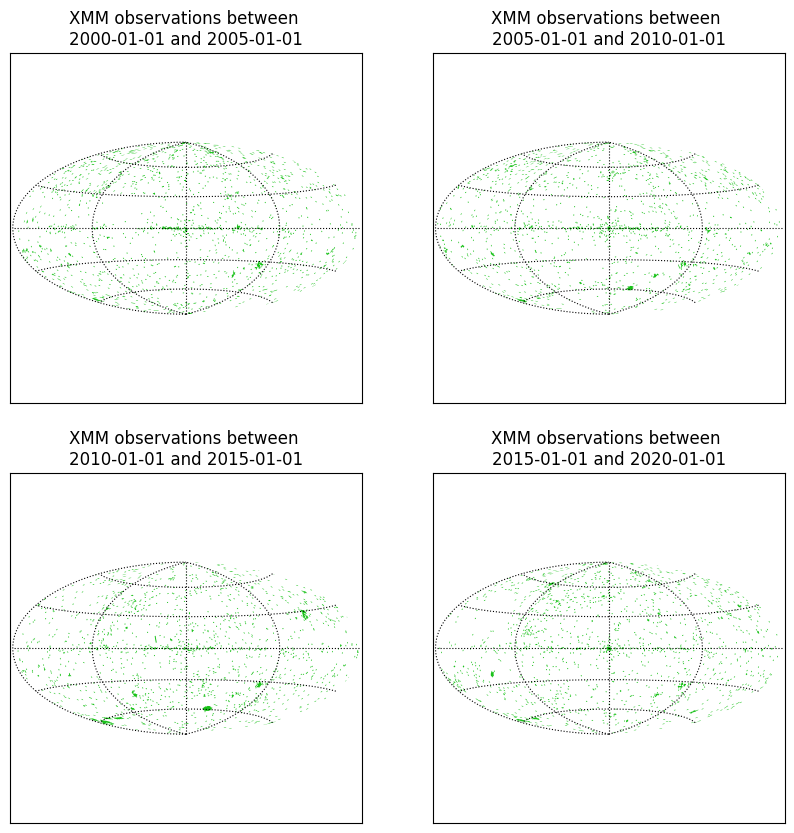

In [61]:
def add_to_plot(fig, label, wcs, title, moc):
    """Add a MOC to a plot."""
    ax = fig.add_subplot(label, projection=wcs)

    ax.grid(color="black", linestyle="dotted")
    ax.set_title(title)
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")

    moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    # moc.border(ax=ax, wcs=wcs, linewidth=1, color="green")


fig = plt.figure(figsize=(10, 10))

time_ranges = Time(
    [
        [["2000-01-01", "2005-01-01"]],
        [["2005-01-01", "2010-01-01"]],
        [["2010-01-01", "2015-01-01"]],
        [["2015-01-01", "2020-01-01"]],
    ],
    format="iso",
    scale="tdb",
    out_subfmt="date",
)
with WCS(
    fig,
    fov=330 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="galactic"),
    coordsys="galactic",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    for i in range(0, 4):
        tmoc = TimeMOC.from_time_ranges(
            min_times=time_ranges[i][0, 0],
            max_times=time_ranges[i][0, 1],
            delta_t=TimeDelta(0.5, scale="tdb", format="jd"),
        )

        moc_2mass = stmoc_xmm.query_by_time(tmoc)
        title = "XMM observations between \n{} and {}".format(
            time_ranges[i][0, 0].iso,
            time_ranges[i][0, 1].iso,
        )
        id_subplot = int("22" + str(i + 1))
        add_to_plot(fig, id_subplot, wcs, title, moc_2mass)

plt.show()

## Now fermi grb

#
The same process can be repeated for Fermi 

In [63]:
fermi_grb_metacat = tap_vizier.search("""select * from METAcat
                              where title like '%Fermi%GRB%'
                              """).to_table()
fermi_grb_metacat


catid,kslot,status,catype,name,title,bibcode,authors,explain,popu,authid,flags,doi,orcid,artdoi
int32,int16,int16,int16,object,object,object,object,object,int32,int32,int32,object,object,object
18930046,54,0,2,J/ApJ/893/46,"The fourth Fermi-GBM GRB catalog: 10 years (von Kienlin+, 2020)",2020ApJ...893...46V,"von Kienlin A., Meegan C.A., Paciesas W.S., et al.",,-1,0,0,10.26093/cds/vizier.18930046,0000-0002-0221-5916,10.3847/1538-4357/ab7a18
18730060,8,0,2,J/ApJ/873/60,"Improved Fermi-GBM GRB localizations using BALROG (Berlato+, 2019)",2019ApJ...873...60B,"Berlato F., Greiner J., Burgess J.M.",,-1,0,0,,0000-0001-8747-0627,10.3847/1538-4357/ab0413
35570100,51,0,5,J/A+A/557/A100,"Fermi and Swift GRBs E_peak_-E_iso_ relation (Heussaff+, 2013)",2013A&A...557A.100H,"Heussaff V., Atteia J.-L., Zolnierowski Y.",,1774,0,0,10.26093/cds/vizier.35570100,,10.1051/0004-6361/201321528
19150086,24,0,2,J/ApJ/915/86,"Swift & Fermi GRBs with LIGO-Virgo run O3a data (Abbott+, 2021)",2021ApJ...915...86A,"Abbott R., Abbott T.D., Abraham S. et al. The LIGO Scientific Collaboration and the Virgo Collaboration.",,-1,0,0,10.26093/cds/vizier.19150086,,10.3847/1538-4357/abee15
74900927,54,0,5,J/MNRAS/490/927,"Bayesian Fermi-GBM short GRB spectral catalogue (Burgess+, 2019)",2019MNRAS.490..927B,"Burgess J.M., Greiner J., Begue D., Berlato F.",,-1,0,0,,0000-0003-3345-9515,10.1093/mnras/stz2589
35880135,54,0,2,J/A+A/588/A135,"Fermi/GBM GRB time-resolved spectral catalog (Yu+, 2016)",2016A&A...588A.135Y,"Yu H.-F., Preece R.D., Greiner J., et al.",,43,0,0,10.26093/cds/vizier.35880135,,10.1051/0004-6361/201527509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17630015,54,0,5,J/ApJ/763/15,"Fermi GRB analysis. III. T_90_ distributions (Qin+, 2013)",2013ApJ...763...15Q,"Qin Y., Liang E.-W., Liang Y.-F., Yi S.-X., Lin L., Zhang B.-B., Zhang J., Lu H.-J., Lu R.-J., Lu L.-Z., Zhang B.",,2197,0,0,10.26093/cds/vizier.17630015,,10.1088/0004-637X/763/1/15
17560112,54,0,2,J/ApJ/756/112,"Fermi/GBM GRB time-resolved spectral analysis (Lu+, 2012)",2012ApJ...756..112L,"Lu R.-J., Wei J.-J., Liang E.-W., Zhang B.-B., Lu H.-J., Lu L.-Z., Lei W.-H., Zhang B.",,1438,0,0,10.26093/cds/vizier.17560112,,10.1088/0004-637X/756/2/112


In [64]:
fermi_grb_catid = 18930046

In [65]:
fermi_grb_tables = tap_vizier.search(f"""select * from METAtab where catid={fermi_grb_catid}
""").to_table()
fermi_grb_tables

name,dbname,dbaid,catid,tabid,notid,flags,equinox,epoch,cooframe,status,explain,comment,records,loadate,release,filename,cooprec,morexplain
,,,,,,,yr,yr,,,,,,,,,mas,
object,object,int16,int32,int16,int16,int16,int16,float64,int16,int16,object,object,int64,int32,int32,object,float32,object
J/ApJ/893/46/table4,c18930046t4,44,18930046,1,0,0,2000,--,5,0,GRB triggers: locations and trigger characteristics,,2360,673015251,709226047,/ftp/cats/J/ApJ/893/46/table4.dat,1800000.0,
J/ApJ/893/46/table5,c18930046t5,44,18930046,2,0,0,--,--,0,0,GRB durations (50-300keV),,2359,673015251,709226047,/ftp/cats/J/ApJ/893/46/table5.dat,--,
J/ApJ/893/46/table6,c18930046t6,44,18930046,3,0,0,--,--,0,0,GRB fluence & peak flux (10-1000keV),,2359,673015251,709226047,/ftp/cats/J/ApJ/893/46/table6.dat,--,
J/ApJ/893/46/table7,c18930046t7,44,18930046,4,0,0,--,--,0,0,GRB fluence & peak flux (50-300keV),,2359,673015251,709226047,/ftp/cats/J/ApJ/893/46/table7.dat,--,
J/ApJ/893/46/table3,c18930046t3,44,18930046,5,0,0,--,--,0,0,Trigger modification history,,995,673015251,709226047,/ftp/cats/J/ApJ/893/46/table3.dat,--,


In [66]:
fermi_grb_triggers_columns = tap_vizier.search("""select * from columns where table_name='J/ApJ/893/46/table4'""").to_table()
fermi_grb_triggers_columns

table_name,column_name,description,unit,ucd,utype,datatype,size,principal,indexed,std
object,object,object,object,object,object,object,int32,int32,int32,int32
J/ApJ/893/46/table4,recno,Record number assigned by the VizieR team. Should Not be used for identification.,,meta.record,,INTEGER,-1,0,0,1
J/ApJ/893/46/table4,Fermi,Trigger identifier (bnYYMMDDddd),,meta.id;meta.main,,CHAR(11),11,0,0,1
J/ApJ/893/46/table4,f_Fermi,[A-Cb-z] Flag on Fermi (1),,meta.code,,CHAR(1),1,0,0,1
J/ApJ/893/46/table4,GRB,Gamma-ray burst identifier (YYMMDDA),,meta.id,,CHAR(7),7,0,0,1
J/ApJ/893/46/table4,Obs,UT date of the observation; date added by CDS,s,time.epoch;obs,,INTEGER,-1,0,0,1
J/ApJ/893/46/table4,RAJ2000,Right Ascension in decimal degrees (J2000),deg,pos.eq.ra;meta.main,,DOUBLE,-1,1,2,1
J/ApJ/893/46/table4,DEJ2000,Declination in decimal degrees (J2000),deg,pos.eq.dec;meta.main,,DOUBLE,-1,1,2,1
J/ApJ/893/46/table4,Error,[0/68.1] Position error,deg,stat.error;pos,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table4,Loc,Location source,,meta.note,,VARCHAR,-1,0,0,1


In [67]:
fermi_grb_durations_columns = tap_vizier.search("""select * from columns where table_name='J/ApJ/893/46/table5'""").to_table()
fermi_grb_durations_columns

table_name,column_name,description,unit,ucd,utype,datatype,size,principal,indexed,std
object,object,object,object,object,object,object,int32,int32,int32,int32
J/ApJ/893/46/table5,recno,Record number assigned by the VizieR team. Should Not be used for identification.,,meta.record,,INTEGER,-1,0,0,1
J/ApJ/893/46/table5,Fermi,Trigger identifier,,meta.id;meta.main,,CHAR(11),11,0,0,1
J/ApJ/893/46/table5,f_Fermi,Flag on Fermi (1),,meta.code,,CHAR(2),2,0,0,1
J/ApJ/893/46/table5,Det,Detectors Used,,meta.id;instr,,VARCHAR,-1,0,0,1
J/ApJ/893/46/table5,T90,[0.008/829] Duration between 5% and 95% of maximum fluence,s,time.interval,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,e_T90,[0.02/54] Uncertainty in T90,s,stat.error,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,T90st,[-808/189] Start of T_90_ burst duration,s,time.start,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,T50,[0.008/737] Duration between 25% and 75% of maximum fluence,s,time.interval,,DOUBLE,-1,0,0,1
J/ApJ/893/46/table5,e_T50,[0.01/40] Uncertainty in T50,s,stat.error,,DOUBLE,-1,0,0,1


In [68]:
# lets get metatime for the trigger table (tabid=1)
fermi_triggers_time_info = tap_vizier.search(
    f"""select * from METAtime JOIN METAcol
    on METAtime.catid = METAcol.catid
    and METAcol.colid = METAtime.colid
    and METAcol.tabid = METAtime.tabid
    where METAcol.catid = {fermi_grb_catid} and METAcol.tabid = 1
    """
).to_table()
fermi_triggers_time_info


catid,tabid,colid,time_syst_id,scale_name,frame_name,time_systematic_err,name,description,time_offset,time_uncertainty,time_representation,id,name2,dbname,catid2,tabid2,colid2,notid,famid,ucdid,type,dbtype,length,flags,morid,fmt,unit,dbunit,vounit,explain,morexplain,utype
int32,int16,int16,int32,object,object,float64,object,object,float64,float64,object,int16,object,object,int32,int16,int16,int16,int16,int32,int16,int16,int32,int16,int16,object,object,object,object,object,object,object
18930046,1,4,14,UT,,1000.0,UT_default,default UT scale frame,--,--,ISO,15120,Obs,Obs,18930046,1,4,0,1363,92530,16,40,4,131,0,%19T,s,s,s,UT date of the observation; date added by CDS,,


In [69]:
# let's query the joined tables (to get event start time and duration)
fermi = tap_vizier.search(
    """select * from "J/ApJ/893/46/table5"
    join "J/ApJ/893/46/table4" USING(Fermi)
    """
).to_table()
fermi

Fermi,recno,f_Fermi,Det,T90,e_T90,T90st,T50,e_T50,T50st,recno2,f_Fermi2,GRB,Obs,RAJ2000,DEJ2000,Error,Loc,Al,Time,Energy,Other
,,,,s,s,s,s,s,s,,,,s,deg,deg,deg,,,ms,keV,
object,int32,object,object,float64,float64,float64,float64,float64,float64,int32,str1,object,int32,float64,float64,float64,object,int16,int16,object,object
bn170110967,1990,,3+4+6+7+8,34.048,12.554,-0.256,25.856,1.28,1.024,1991,,,537405171,49.6,12.1,7.2,"Fermi, GBM FSW",11,512,47-291,
bn120412920,903,,2+5,101.182,4.871,0.003,11.264,0.572,71.745,903,,120412B,387583481,38.9,7.1,2.8,Fermi-GBM,9,256,47-291,K
bn080714086,1,,3+4+8,5.376,2.36,-0.768,2.816,0.81,-0.256,1,,080714B,269316252,41.9,8.5,7.5,Fermi-GBM,10,512,47-291,K
bn170305256,2038,b,0+1+2,0.448,0.072,-0.032,0.128,0.045,0.032,2039,,170305A,542009347,38.7,12.1,3.7,"Fermi, GBM FSW",1,16,47-291,"K, IA, P, ARR"
bn091005679,320,,6+7+8+11,6.976,0.572,-4.672,3.136,0.73,-1.984,320,,091005A,308074650,43.1,12.1,5.1,Fermi-GBM,12,1024,47-291,
bn140414693,1350,,0+1+3+4+5,25.6,2.202,-11.776,7.424,0.724,1.28,1350,,,450808718,45.7,13.8,2.3,Fermi-GBM,8,256,47-291,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bn121123421,1037,,3+4+5,102.338,31.849,3.84,34.625,8.155,18.56,1037,d,121123A,406980361,307.3,-11.9,0.0,Swift,17,4096,47-291,"S, W"


In [70]:
# we have to define a specific time for vizier 

from astropy.time.formats import erfa, TimeFromEpoch
class TimeVizier(TimeFromEpoch):
    name = "viztime"
    unit = 1.0 / erfa.DAYSEC  # in days (1 day == 86400 seconds)
    epoch_val = "2000-01-01 00:00:00"
    epoch_val2 = None
    epoch_scale = "utc"
    epoch_format = "iso"

In [71]:
fermi["start_time"] = Time(fermi["Obs"] - erfa.DAYSEC / 2., format="viztime", scale="utc")
fermi["end_time"] = Time(fermi["Obs"] + erfa.DAYSEC / 2., format="viztime", scale="utc")
fermi

Fermi,recno,f_Fermi,Det,T90,e_T90,T90st,T50,e_T50,T50st,recno2,f_Fermi2,GRB,Obs,RAJ2000,DEJ2000,Error,Loc,Al,Time,Energy,Other,start_time,end_time
,,,,s,s,s,s,s,s,,,,s,deg,deg,deg,,,ms,keV,,,
object,int32,object,object,float64,float64,float64,float64,float64,float64,int32,str1,object,int32,float64,float64,float64,object,int16,int16,object,object,Time,Time
bn170110967,1990,,3+4+6+7+8,34.048,12.554,-0.256,25.856,1.28,1.024,1991,,,537405171,49.6,12.1,7.2,"Fermi, GBM FSW",11,512,47-291,,537361971.0,537448371.0
bn120412920,903,,2+5,101.182,4.871,0.003,11.264,0.572,71.745,903,,120412B,387583481,38.9,7.1,2.8,Fermi-GBM,9,256,47-291,K,387540281.0,387626681.0
bn080714086,1,,3+4+8,5.376,2.36,-0.768,2.816,0.81,-0.256,1,,080714B,269316252,41.9,8.5,7.5,Fermi-GBM,10,512,47-291,K,269273052.0,269359452.0
bn170305256,2038,b,0+1+2,0.448,0.072,-0.032,0.128,0.045,0.032,2039,,170305A,542009347,38.7,12.1,3.7,"Fermi, GBM FSW",1,16,47-291,"K, IA, P, ARR",541966147.0,542052547.0
bn091005679,320,,6+7+8+11,6.976,0.572,-4.672,3.136,0.73,-1.984,320,,091005A,308074650,43.1,12.1,5.1,Fermi-GBM,12,1024,47-291,,308031450.0,308117850.0
bn140414693,1350,,0+1+3+4+5,25.6,2.202,-11.776,7.424,0.724,1.28,1350,,,450808718,45.7,13.8,2.3,Fermi-GBM,8,256,47-291,,450765518.0,450851918.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bn121123421,1037,,3+4+5,102.338,31.849,3.84,34.625,8.155,18.56,1037,d,121123A,406980361,307.3,-11.9,0.0,Swift,17,4096,47-291,"S, W",406937161.0,407023561.0


In [72]:
stmoc_fermi = STMOC.from_time_ranges_positions(
    times_start=fermi["start_time"],
    times_end=fermi["end_time"],
    lon = Longitude(fermi["RAJ2000"]),
    lat = Latitude(fermi["DEJ2000"]),
    time_depth=26, spatial_depth=5  # ask Ada why 5 here
)

# 
Now using the STMOC information for both XMM and Fermi, we can use intersection method to identify the common space-time regions covered by both Fermi and XMM-Newton observations. Additionally, all the events, that have been identified, are confirmed by two different telescopes, therefore we can know for certain that the GRBs identified are genuine. These give as output the time when both the telescopes with pointing at the same area of the sky. These come in handy specially for identifing simultaneous observations, which are crucial for multi-wavelength studies of transient events like Gamma-Ray Bursts (GRBs).

In [74]:
intersection = stmoc_fermi.intersection(stmoc_xmm)
intersection

t26/6172445 
s6/37910 
t26/6173274-6173275 
s6/16282 
t26/6176320 
s6/9576 
t26/6177369 
s6/17030 
t26/6177448 
s6/26013 

# 
By now we have seen the power of using STMOCs to identifying transcients events such as GRBs. This method can also be applied for 
different astrophysical objects such as supernova remnants which emit at different wavelengths. STMOCs is a powerful tool which
facilitates the identification of temporal and spatial overlaps, enabling comprehensive multi-wavelength analyses and efficient data management, ultimately advancing our understanding of the object
of interest.

In [75]:
hess = "J/A+A/612/A3"
super_nova_remnant = "RX J1713.7-3946"

In [42]:
from astroquery.simbad import Simbad

In [43]:
Simbad.query_object("RX J1713.7-3946")

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,matched_id
,deg,deg,mas,mas,deg,,,
object,float64,float64,float32,float32,int16,str1,object,object
SNR G347.3-00.5,258.1125,-39.68666666666666,--,--,--,,2012ApJ...756....5L,RX J1713.7-3946


In [44]:
help(intersection.contains)

Help on method contains in module mocpy.stmoc.stmoc:

contains(times, lon, lat, inside=True) method of mocpy.stmoc.stmoc.STMOC instance
    Return a boolean mask array of the (times, positions) lying inside (or outside) the Space-Time coverage.
    
    Parameters
    ----------
    times : `astropy.time.Time`
        The times of each sky coordinates.
    lon : `astropy.units.Quantity`
        The longitudes of the sky coordinates observed at a specific time.
    lat : `astropy.units.Quantity`
        The latitudes of the sky coordinates observed at a specific time.
    inside : bool, optional
        True by default. The returned mask array has true values for (time, position)
        lying inside the Space-Time coverage.
    
    Raises
    ------
    ValueError : If `times`, `lon` and `lat` do not have the same length.
    
    Returns
    -------
    array : `~np.ndarray`
        A mask boolean array



In [45]:
only_space = MOC.from_string("6/37910 16282 9576 17030 26013")

In [46]:
from astropy.coordinates import Longitude, Latitude

In [47]:
only_space.contains_lonlat(lon=Longitude("17 12 27", unit="deg"), lat=Latitude("-39 41.2", unit="deg"))

array([False])

In [48]:
only_space.query_vizier_table("J/A+A/612/A3")

_RAJ2000,_DEJ2000,Source,GLON,GLAT,RON,Type,Dist,LTime,Avzenith,CDetec,Sep,Ful,signi,Wpxnul,Weul,Simbad,_RA.icrs,_DE.icrs
deg,deg,,deg,deg,deg,,kpc,h,deg,,deg,1e-13cm**-2.s**-1,,1e+41W,1e+38W,,deg,deg
float64,float64,str10,float32,float32,float32,object,float32,float32,float32,str14,float32,float32,float32,float32,float32,object,float64,float64


In [49]:
fermi_grbs_intersection = only_space.query_vizier_table("J/ApJ/893/46")
fermi_grbs_intersection

_RAJ2000,_DEJ2000,Fermi,f_Fermi,GRB,_tab1_4,RAJ2000,DEJ2000,Error,Loc,Al,Time,Energy,Other,Simbad
deg,deg,,,,s,deg,deg,deg,,,ms,keV,,
float64,float64,str11,str1,str7,str19,float32,float32,float32,object,int16,int16,str6,object,object
176.8000,-60.2000,bn080723557,,080723B,2008-07-23T13:22:21,176.8,-60.2,0.0,Swift,8,256,47-291,"K, IA, IS, Me, A",Simbad
294.0000,78.4000,bn090618353,,090618A,2009-06-18T08:28:27,294.0,78.4,0.0,Swift,10,512,47-291,"Mo, K, R, IA, S, W, A",Simbad
260.2000,41.1000,bn121011469,,121011A,2012-10-11T11:15:26,260.2,41.1,0.0,Swift,14,2048,47-291,"L, S, W",Simbad
344.1000,-21.7000,bn131202633,,131202A,2013-12-02T15:12:11,344.1,-21.7,0.0,Swift,16,4096,47-291,S,Simbad
211.9000,1.3000,bn140102887,,140102A,2014-01-02T21:17:38,211.9,1.3,0.0,Swift,4,64,47-291,"L, S, M, K, ARR",Simbad
212.0000,1.1000,bn150906944,,,2015-09-06T22:38:47,212.0,1.1,5.2,Fermi-GBM,1,16,47-291,IA,Simbad


In [50]:
aladin.add_table(fermi_grbs_intersection, color="hotpink", shape="cross")

In [58]:
simbad = Simbad()
simbad.add_votable_fields("flux")

In [60]:
simbad_result = simbad.query_objects([f"Fermi {id}" for id in fermi_grbs_intersection["Fermi"]])
simbad_result

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,bibcode,filter,flux,flux_err,flux_err_prec,flux_prec,qual,user_specified_id,object_number_id
,deg,deg,mas,mas,deg,,,,,,,,,,,
object,float64,float64,float32,float32,int16,str1,object,object,object,float32,float32,int16,int16,str1,object,int64
GRB 080723B,176.83237499999998,-60.24108333333334,1500.0,1500.0,90,X,2009MNRAS.397.1177E,,,--,--,--,--,,Fermi bn080723557,1
GRB 090618,294.00750000000005,78.35197222222222,--,--,--,,2009GCNR..232....1S,,,--,--,--,--,,Fermi bn090618353,2
Fermi bn121011469,260.2136249999999,41.11022222222222,1400.0,1400.0,0,X,url:SWIFT,,,--,--,--,--,,Fermi bn121011469,3
Fermi bn131202633,344.05425,-21.66247222222222,1900.0,1900.0,0,X,2013GCN.15564....1O,,,--,--,--,--,,Fermi bn131202633,4
Fermi bn140102887,211.919375,1.3332777777777776,500.0,500.0,0,U,2014GCN.15690....1H,,,--,--,--,--,,Fermi bn140102887,5
Fermi bn150906944,212.04,1.0899999999999999,--,--,--,,2017ApJ...843...88A,,,--,--,--,--,,Fermi bn150906944,6


In [61]:
only_space.query_vizier_table("IX/69")

_RAJ2000,_DEJ2000,Source,_4XMM,RA_ICRS,DE_ICRS,srcML,Flux8,e_Flux8,HR1,HR2,HR3,HR4,ext,V,S,Nd,uIRAP,xcatDB
deg,deg,,,deg,deg,,mW.m**-2,mW.m**-2,,,,,arcsec,,,,,
float64,float64,int64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,int16,str54,object
176.45906111,-60.34622000,205601914010071,J114550.1-602046,176.459061,-60.346220,37.928,6.8223e-15,5.3127e-15,0.387129,-0.502714,-0.873113,-1.000000,0.000000,0,0,1,http://xmm-catalog.irap.omp.eu/source/205601914010071/,xcatDB
176.47886000,-60.39860389,205601914010120,J114554.9-602354,176.478860,-60.398604,7.5627,8.5253e-14,3.6651e-14,0.526593,-0.103980,-1.000000,1.000000,0.000000,0,0,1,http://xmm-catalog.irap.omp.eu/source/205601914010120/,xcatDB
176.48886000,-60.23820000,205601914010098,J114557.3-601417,176.488860,-60.238200,23.854,2.3885e-14,8.4171e-15,0.678272,0.463470,0.067105,0.032740,0.000000,0,0,1,http://xmm-catalog.irap.omp.eu/source/205601914010098/,xcatDB
176.49033194,-60.11994306,205601914010095,J114557.6-600711,176.490332,-60.119943,16.31,2.179e-14,1.2245e-14,1.000000,0.877248,0.221539,-0.565142,0.000000,0,0,1,http://xmm-catalog.irap.omp.eu/source/205601914010095/,xcatDB
176.49627806,-60.14858000,205601914010014,J114559.1-600854,176.496278,-60.148580,194.05,8.8015e-14,1.5589e-14,0.359557,0.943135,0.176081,-0.291697,0.000000,0,1,1,http://xmm-catalog.irap.omp.eu/source/205601914010014/,xcatDB
176.50848306,-60.28993500,205601914010034,J114602.0-601723,176.508483,-60.289935,58.127,2.4552e-14,8.2495e-15,-0.277581,0.964741,0.253600,-0.601336,0.000000,0,1,1,http://xmm-catalog.irap.omp.eu/source/205601914010034/,xcatDB
176.54147694,-60.39928000,205601914010015,J114609.9-602357,176.541477,-60.399280,161.09,3.5096e-14,8.2974e-15,0.598582,-0.090219,-0.935831,-1.000000,0.000000,0,0,1,http://xmm-catalog.irap.omp.eu/source/205601914010015/,xcatDB
176.54565194,-60.22619194,205601914010113,J114610.9-601334,176.545652,-60.226192,12.103,1.0398e-14,6.0236e-15,0.645516,0.336215,-0.137931,-0.085810,0.000000,0,0,1,http://xmm-catalog.irap.omp.eu/source/205601914010113/,xcatDB
